In [3]:
# Energy-based Controller for Pendulum Swing up
using PyPlot
using StaticArrays
using RigidBodyDynamics

In [4]:
# Define a few constants
g = -9.81 # m/s^2

# Setup the world and Mechanism type
world = RigidBody{Float64}("world")
pendulum = Mechanism(world; gravity = SVector(0,0,g))

# location of principle axis to rotate about
axis = SVector(0., 1., 0.)

# Mass information
I   = 1/3.
COM = -0.5
m   = 1.

# Frames
frame1   = CartesianFrame3D("arm")
inertia1 = SpatialInertia(frame1, I*axis*axis', m*SVector(0, 0, COM), m)

# Definitions
arm = RigidBody(inertia1)
shoulder = Joint("shoulder", Revolute(axis))

# Complete mechanism
before_shoulder_to_world = eye(Transform3D, frame_before(shoulder), default_frame(world))
attach!(pendulum, world, arm, shoulder, joint_pose = before_shoulder_to_world)

Spanning tree:
Vertex: world (root)
  Vertex: arm, Edge: shoulder
No non-tree joints.

In [5]:
# Definition of initial state
state0 = MechanismState(pendulum)

configuration(state0, shoulder)[:] = 0.01
velocity(state0, shoulder)[:] = 0.
setdirty!(state0)

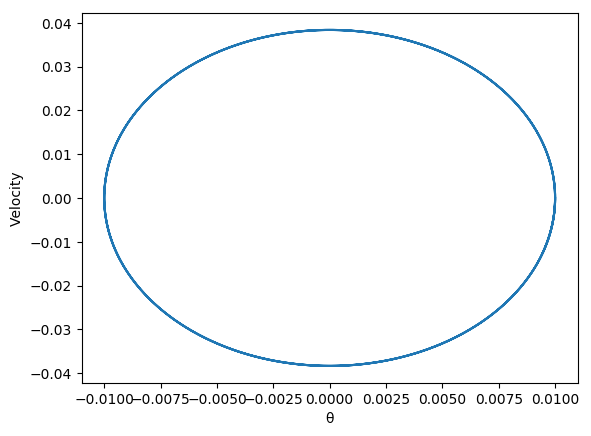

In [6]:
# Simulate system response
tend = 5. # 5s 
ts, qs, vs = simulate(state0, tend; Δt = 1e-3);

# Plot it
plot(qs,vs);
xlabel("θ"); ylabel("Velocity");

In [7]:
# Testing with damping added to system
C = 1.
tend = 5.
Δt = 1e-4

function damping!(torque::AbstractVector, t, state::MechanismState)
    torque = -C*velocity(state,shoulder)
end

damping! (generic function with 1 method)

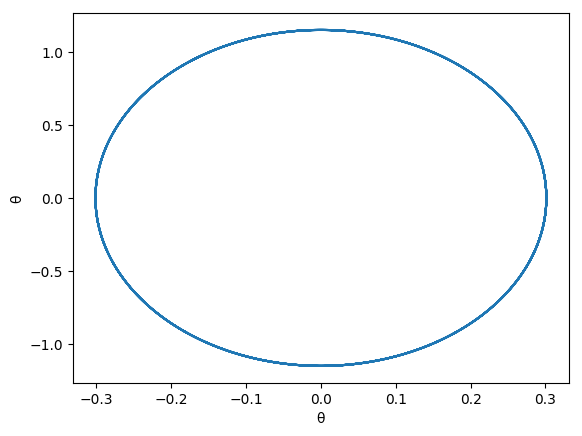

In [11]:
# Simulate
ts, qs, vs = simulate(state0, tend, damping!; Δt = 1e-3);

plot(qs,vs);
xlabel("θ"); ylabel("θ");

In [16]:
# Energy Shaping Control
# Using a controller to try and swing up to the top position, θ = pi.
# Derivation of controller in Pendulum Plots/swingup_derivation

E_d = m*g*1; # Desired Energy State (max)
Ke = 1; # Energy Gain
Kp = 1; # Proportional Gain
Kd = 0.1; # Derivative Gain

function swingup!(torque::AbstractVector, state::MechanismState)
    E_current = 0.5*m*1^2*velocity(state,shoulder).^2 + m*g*1*(-cos.(configuration(state,shoulder)))
    e_energy = E_current-E_d
    torque = -Ke.*velocity(state,shoulder).*e_energy  
#     println("Torque $(t), u = $(torque)")
end

function position_control!(torque::AbstractVector, state::MechanismState)
    torque = Kp*(pi-configuration(state,shoulder)) -Kd*velocity(state,shoulder)
end

function swingup_control!(torque::AbstractVector, t, state::MechanismState)
    if abs.(configuration(state,shoulder) - pi)[1] < 0.01
        position_control!(torque, state) - velocity(state,shoulder)
    else
        swingup!(torque, state) - velocity(state,shoulder)
    end
end

swingup_control! (generic function with 1 method)

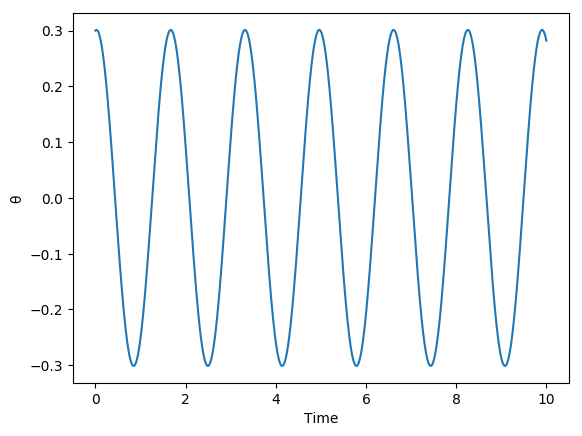

In [17]:
# Definition of initial state
configuration(state0, shoulder)[:] = 0.3
velocity(state0, shoulder)[:] = 0.1
setdirty!(state0)

# Simulate
tend = 10.
ts, qs, vs = simulate(state0, tend, swingup_control!; Δt = 1e-3);

plot(ts, qs);
xlabel("Time"); ylabel("θ");